### Load dataset and rename columns
> Note: **Only AMST** are contained in df. HNK products where filtered.

In [1]:
import pandas as pd
import numpy as np
from re import sub

def column_name_to_snake_case(s):
    s = sub(r"[\/( \- ) ]", '_', s)
    s = sub(r"(___)|(__)", '_', s).lower()
    return s if s[-1] != '_' else s[:-1]

df = pd.read_csv(r'..\data\raw\Heineken - Data Science Use Case.csv', parse_dates=['Date/Time'])
df = (df.drop(columns=df.columns[0])
        .rename(columns={col:column_name_to_snake_case(col) for col in df.columns[1:]})
        .query('product == "AMST"')
     )

### Rows with null values

In [2]:
nulls = df[pd.isnull(df).any(axis=1)]

#### Analyzing target (color) null values
All color null values have no other null value besides the target column.
> They will be used as a test dataset

In [3]:
target = nulls.query('color.isnull()')
print(target.drop('color', axis=1).isnull().sum(axis=0))

# saving to parse dtypes faster later 
dtypes = {col:target[col].dtype for col in target.columns}

target.to_csv(r'..\data\test\test_data.csv', index=False)



job_id                0
date_time             0
roast_amount_kg       0
1st_malt_amount_kg    0
2nd_malt_amount_kg    0
mt_temperature        0
mt_time               0
wk_temperature        0
wk_steam              0
wk_time               0
total_cold_wort       0
ph                    0
extract               0
woc_time              0
whp_transfer_time     0
whp_rest_time         0
roast_color           0
1st_malt_color        0
2nd_malt_color        0
product               0
dtype: int64


#### Check non_target nulls

In [75]:
non_target = nulls.query('color.notnull()')
print('non_target nulls len:', len(non_target), '\n')
print(non_target.drop('color', axis=1).isnull().sum(axis=0)[lambda x: x >0])

non_target.to_csv('..\data\dropped_nulls\dropped_rows.csv', index=False)
with open(r'..\data\dropped_nulls\readme.md', 'w') as file:
    file.write("Dropped nulls from original dataset. \nTarget columns nulls were kept to be used as test dataset")


non_target nulls len: 8 

roast_amount_kg    3
ph                 5
dtype: int64


### Features

In [40]:
import seaborn as sns
features = (df.select_dtypes(include='number')
             .drop(columns=['job_id','color'])
             .dropna()
             )
feature_cols = features.columns
features.describe()


,roast_amount_kg,1st_malt_amount_kg,2nd_malt_amount_kg,mt_temperature,mt_time,wk_temperature,wk_steam,wk_time,total_cold_wort,ph,extract,woc_time,whp_transfer_time,whp_rest_time,roast_color,1st_malt_color,2nd_malt_color
count,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000,172.000000,172.000000
mean,38.513753,13647.679088,6718.016278,67.838056,6743.593750,105.257272,6707.250000,6762.056250,941.350000,5.568080,15.279536,3132.262500,752.943750,14.495312,908.375,6.053750,6.019375
std,17.767978,759.014521,1125.345280,2.873195,416.384412,0.595675,269.132155,555.359239,126.231177,0.624408,0.964639,554.792997,64.485314,0.007342,0.000,0.079298,0.014225
min,17.415013,12209.474170,3996.957605,66.866813,6458.600000,97.659771,6170.500000,5929.700000,68.800000,2.295564,6.796530,107.500000,719.175000,14.476667,908.375,5.912500,5.912500
25%,24.483118,12596.823230,6069.181250,66.933041,6614.475000,105.202896,6546.750000,6552.662500,956.750000,5.549443,15.225333,3125.831250,731.000000,14.494583,908.375,6.020000,6.020000
50%,27.735052,14024.444750,6075.335730,67.002759,6683.812500,105.269124,6654.250000,6659.087500,963.200000,5.618374,15.448131,3146.525000,736.375000,14.494583,908.375,6.020000,6.020000
75%,54.206845,14081.935993,8326.369589,67.184886,6771.693750,105.373703,6807.437500,6795.075000,971.800000,5.701578,15.625732,3173.668750,743.900000,14.494583,908.375,6.127500,6.020000
max,88.042526,16067.852830,8462.077710,81.452861,11671.275000,105.718793,8202.250000,12621.575000,1088.975000,7.382991,16.320075,5743.725000,1241.625000,14.584167,908.375,6.127500,6.127500


### Check normality of features

In [68]:
from scipy.stats import shapiro, kstest

shapiro_p_value = [shapiro(df[col].values).pvalue for col in feature_cols]
kstest_p_value = [kstest(df[col].values, 'norm').pvalue for col in feature_cols]
normality_tests = pd.DataFrame(
    {'columns': feature_cols, 'shapiro_p_value': shapiro_p_value, 'kstest_p_value': kstest_p_value})
normality_tests['failed'] = normality_tests.apply(lambda row: 'yes' if row['shapiro_p_value'] > 0.05 or row['kstest_p_value'] > 0.05 else 'no', axis=1)
normality_tests

c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,columns,shapiro_p_value,kstest_p_value,failed
0,roast_amount_kg,1.000000e+00,NaN,yes
1,1st_malt_amount_kg,1.174284e-22,0.0,no
2,2nd_malt_amount_kg,2.723439e-17,0.0,no
3,mt_temperature,2.806055e-25,0.0,no
4,mt_time,1.103082e-25,0.0,no
5,wk_temperature,1.643726e-27,0.0,no
6,wk_steam,6.888419e-13,0.0,no
7,wk_time,1.118321e-23,0.0,no
8,total_cold_wort,2.281583e-26,0.0,no
9,ph,1.000000e+00,NaN,yes


#### evaluate non normal features

C:\Users\gabri\AppData\Local\Temp\ipykernel_1248\3532477185.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed['log_'+col] = failed[col].apply(lambda x: np.power(x,1/3))
C:\Users\gabri\AppData\Local\Temp\ipykernel_1248\3532477185.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed['log_'+col] = failed[col].apply(lambda x: np.power(x,1/3))
C:\Users\gabri\AppData\Local\Temp\ipykernel_1248\3532477185.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

array([[<Axes: title={'center': 'roast_amount_kg'}>,
        <Axes: title={'center': 'ph'}>],
       [<Axes: title={'center': 'roast_color'}>,
        <Axes: title={'center': 'log_roast_amount_kg'}>],
       [<Axes: title={'center': 'log_ph'}>,
        <Axes: title={'center': 'log_roast_color'}>]], dtype=object)

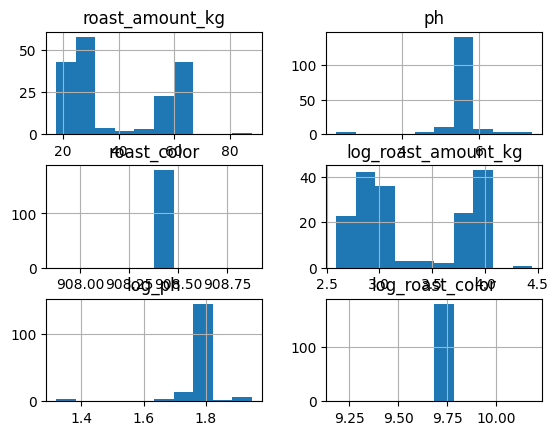

In [85]:
import numpy as np
failed = df[normality_tests.query('shapiro_p_value > 0.05 or kstest_p_value > 0.05')['columns'].values]
for col in failed.columns:
    failed['log_'+col] = failed[col].apply(lambda x: np.power(x,1/3))
failed.hist()



